# Redes Neurais Artificiais - Identificação de Websites de *Phishing*
Atividade Avaliativa 3 - *Hands-On*

#### Problema:
- Identificação de Websites *Phishing* por uso de Redes Neurais Artificiais e AutoML

#### Dataset:
- "[*Website Phishing*](https://archive.ics.uci.edu/dataset/379/website+phishing)" por Neda Abdelhamid

#### Equipe:
- Daniele Simas Guimaraes - 2015310060
- Felipe Muniz Amorim - 2115080033
- Jose Manuel Coelho Dos Santos - 2115080052

## Importação de bibliotecas

In [105]:
import arff
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

## Carregando os dados

Classes dos atributos:

| Legítimo | Suspeito | Phishing |
|  ------  |  ------  |  ------  |
|    1     |     0    |    -1    |

In [106]:
dataset = None

with open('data/PhishingData.arff', 'r') as file:
    data = arff.load(file)

    dataset = pd.DataFrame(data['data'], columns=[attr[0] for attr in data['attributes']])

dataset

,SFH,popUpWidnow,SSLfinal_State,Request_URL,URL_of_Anchor,web_traffic,URL_Length,age_of_domain,having_IP_Address,Result
0,1,-1,1,-1,-1,1,1,1,0,0
1,-1,-1,-1,-1,-1,0,1,1,1,1
2,1,-1,0,0,-1,0,-1,1,0,1
3,1,0,1,-1,-1,0,1,1,0,0
4,-1,-1,1,-1,0,0,-1,1,0,1
...,...,...,...,...,...,...,...,...,...,...
1348,-1,-1,-1,-1,-1,-1,0,1,0,1
1349,-1,0,1,0,-1,0,0,1,0,-1
1350,-1,0,-1,-1,-1,0,-1,-1,0,1
1351,0,0,1,0,0,0,-1,1,0,1


In [107]:
print('# Tipos das colunas:')
print(dataset.dtypes, end='\n\n')

print("# Após conversão:")
dataset = dataset.astype(int)
print(dataset.dtypes)

# Tipos das colunas:
SFH                  object
popUpWidnow          object
SSLfinal_State       object
Request_URL          object
URL_of_Anchor        object
web_traffic          object
URL_Length           object
age_of_domain        object
having_IP_Address    object
Result               object
dtype: object

# Após conversão:
SFH                  int64
popUpWidnow          int64
SSLfinal_State       int64
Request_URL          int64
URL_of_Anchor        int64
web_traffic          int64
URL_Length           int64
age_of_domain        int64
having_IP_Address    int64
Result               int64
dtype: object


## Exploração

In [108]:
print(f"Quantidade de exemplos: {len(dataset)}")
print(f"Quantidade de exemplos legítimos: {len(dataset[dataset['Result'] == 1])}")
print(f"Quantidade de exemplos suspeitos: {len(dataset[dataset['Result'] == 0])}")
print(f"Quantidade de exemplos phishing: {len(dataset[dataset['Result'] == -1])}")

Quantidade de exemplos: 1353
Quantidade de exemplos legítimos: 548
Quantidade de exemplos suspeitos: 103
Quantidade de exemplos phishing: 702


In [109]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1353 entries, 0 to 1352
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   SFH                1353 non-null   int64
 1   popUpWidnow        1353 non-null   int64
 2   SSLfinal_State     1353 non-null   int64
 3   Request_URL        1353 non-null   int64
 4   URL_of_Anchor      1353 non-null   int64
 5   web_traffic        1353 non-null   int64
 6   URL_Length         1353 non-null   int64
 7   age_of_domain      1353 non-null   int64
 8   having_IP_Address  1353 non-null   int64
 9   Result             1353 non-null   int64
dtypes: int64(10)
memory usage: 105.8 KB


In [110]:
for column in dataset.columns:
    print(f"Coluna '{column}': ".ljust(28) + "{" + ",".join(str(value) for value in sorted(dataset[column].unique())) + "}")

Coluna 'SFH':               {-1,0,1}
Coluna 'popUpWidnow':       {-1,0,1}
Coluna 'SSLfinal_State':    {-1,0,1}
Coluna 'Request_URL':       {-1,0,1}
Coluna 'URL_of_Anchor':     {-1,0,1}
Coluna 'web_traffic':       {-1,0,1}
Coluna 'URL_Length':        {-1,0,1}
Coluna 'age_of_domain':     {-1,1}
Coluna 'having_IP_Address': {0,1}
Coluna 'Result':            {-1,0,1}


A coluna `having_IP_Address` é inconsistente com a documentação do dataset no artigo, e deveria possuir as classes binárias `{-1, 1}`. Vamos realizar essa troca substituindo todas as ocorrências do valor `0` na coluna por `1`.

In [111]:
dataset['having_IP_Address'] = dataset['having_IP_Address'].replace(0, -1)

print(f"Coluna 'having_IP_Address': " + "{" + ",".join(str(value) for value in sorted(dataset["having_IP_Address"].unique())) + "}")


Coluna 'having_IP_Address': {-1,1}


In [112]:
dataset.head()

,SFH,popUpWidnow,SSLfinal_State,Request_URL,URL_of_Anchor,web_traffic,URL_Length,age_of_domain,having_IP_Address,Result
0,1,-1,1,-1,-1,1,1,1,-1,0
1,-1,-1,-1,-1,-1,0,1,1,1,1
2,1,-1,0,0,-1,0,-1,1,-1,1
3,1,0,1,-1,-1,0,1,1,-1,0
4,-1,-1,1,-1,0,0,-1,1,-1,1


A coluna `popupWindow` está intitulada incorretamente.

In [113]:
dataset.rename(columns={'popUpWidnow': 'popUp_Window'}, inplace=True)
dataset.head()

,SFH,popUp_Window,SSLfinal_State,Request_URL,URL_of_Anchor,web_traffic,URL_Length,age_of_domain,having_IP_Address,Result
0,1,-1,1,-1,-1,1,1,1,-1,0
1,-1,-1,-1,-1,-1,0,1,1,1,1
2,1,-1,0,0,-1,0,-1,1,-1,1
3,1,0,1,-1,-1,0,1,1,-1,0
4,-1,-1,1,-1,0,0,-1,1,-1,1


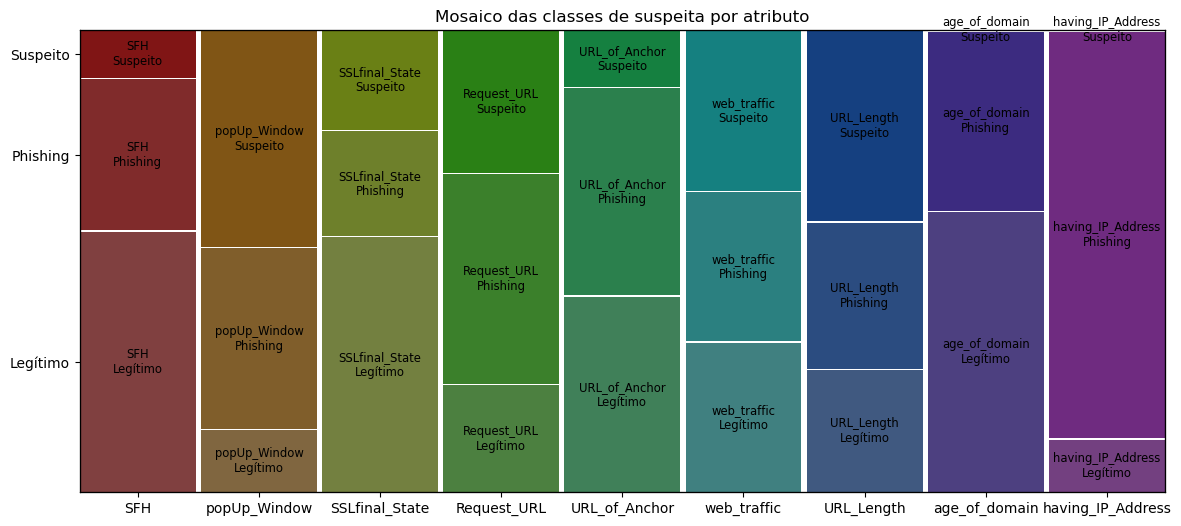

In [122]:
named_categories = dataset.replace(0, 'Suspeito')
named_categories = named_categories.replace(1, 'Legítimo')
named_categories = named_categories.replace(-1, 'Phishing')
named_categories.drop(columns=["Result"], inplace=True)

mosaic_data = named_categories.melt(var_name='Atributo', value_name='Suspect')

fig, ax = plt.subplots(figsize=(14,6))
mosaic(mosaic_data, ['Atributo', 'Suspect'], ax=ax, title="Mosaico das classes de suspeita por atributo")

plt.show()

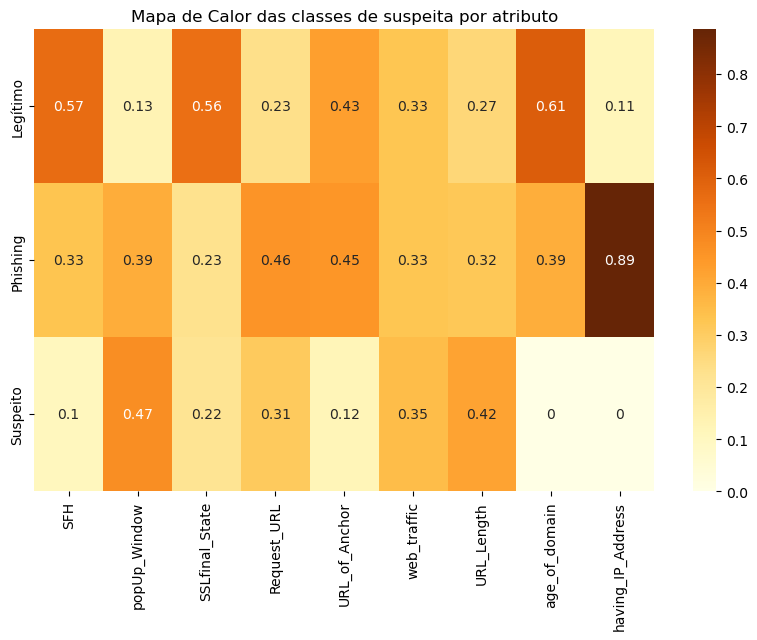

In [115]:
count_matrix = named_categories.apply(lambda x: x.value_counts()).fillna(0)
percentage_matrix = count_matrix.div(count_matrix.sum(axis=0), axis=1)

plt.figure(figsize=(10,6))
sns.heatmap(percentage_matrix, annot=True, cmap=sns.color_palette("YlOrBr", as_cmap=True), cbar=True)

plt.title('Mapa de Calor das classes de suspeita por atributo')
plt.show()

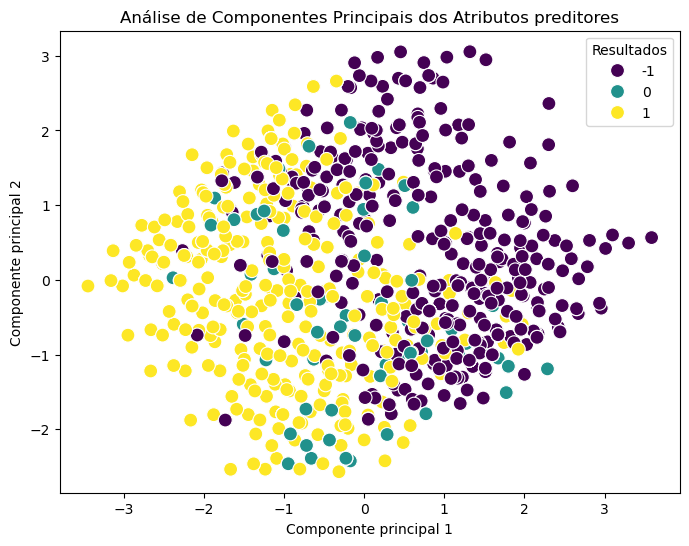

In [119]:
features = dataset.copy()
features.drop(columns=['Result'], inplace=True)
target = dataset['Result']

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Perform PCA
pca = PCA(n_components=2)  # Reduce to 2 components for visualization
pca_result = pca.fit_transform(features_scaled)

# Convert PCA results to DataFrame
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
pca_df['Result'] = target

# Plot PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Result', palette='viridis', s=100)

plt.title('Análise de Componentes Principais dos Atributos preditores')
plt.xlabel('Componente principal 1')
plt.ylabel('Componente principal 2')
plt.legend(title='Resultados')

plt.show()
